### Setup

In [ ]:
# colab only setup uncomment to install dependencies
%%bash
pip install -q \
    torch>=2.9.1 \
    torchaudio>=2.9.1 \
    transformers>=4.57.0 \
    k2==1.24.4.dev20251118+cuda12.8.torch2.9.1 \
    soundfile==0.31.1 \
    librosa==0.11.0 \
    pyarabic==0.6.10

In [1]:
import torch
import k2

In [2]:
import k2.version
k2.version.version.main()


k2 version: 1.24.4
Build type: Release
Git SHA1: 30c3039fbe89f245d5dba3c47e99abc3a638275f
Git date: Tue Nov 18 07:41:31 2025
Cuda used to build k2: 12.8
cuDNN used to build k2: 
Python version used to build k2: 3.12
OS used to build k2: AlmaLinux release 8.10 (Cerulean Leopard)
CMake version: 4.1.2
GCC version: 13.3.1
CMAKE_CUDA_FLAGS: -Wno-deprecated-gpu-targets -lineinfo --expt-extended-lambda -use_fast_math -Xptxas=-w --expt-extended-lambda -gencode arch=compute_50,code=sm_50 -lineinfo --expt-extended-lambda -use_fast_math -Xptxas=-w --expt-extended-lambda -gencode arch=compute_60,code=sm_60 -lineinfo --expt-extended-lambda -use_fast_math -Xptxas=-w --expt-extended-lambda -gencode arch=compute_61,code=sm_61 -lineinfo --expt-extended-lambda -use_fast_math -Xptxas=-w --expt-extended-lambda -gencode arch=compute_70,code=sm_70 -lineinfo --expt-extended-lambda -use_fast_math -Xptxas=-w --expt-extended-lambda -gencode arch=compute_75,code=sm_75 -lineinfo --expt-extended-lambda -use_fast_

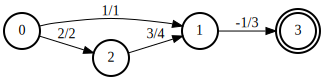

In [3]:
s = '''
0 1 1 1
0 2 2 2
1 3 -1 3
2 1 3 4
3
'''
fsa = k2.Fsa.from_str(s)
k2.to_dot(fsa)

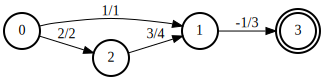

In [4]:
syms = '''
<eps> 0
a 1
b 2
c 3
'''
fsa.symbols = k2.SymbolTable.from_str(syms)
k2.to_dot(fsa)

### English Exp

In [5]:
import torch, k2, soundfile as sf, numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, AutoModelForCTC


model_name = "facebook/wav2vec2-base-960h"
processor  = Wav2Vec2Processor.from_pretrained(model_name)
model      = AutoModelForCTC.from_pretrained(model_name).cuda().eval()

vocab = list(processor.tokenizer.get_vocab().keys())
id2tok = {v: k for k, v in processor.tokenizer.get_vocab().items()}
blank_id = processor.tokenizer.pad_token_id

if blank_id is None:
        blank_id = processor.tokenizer.word_delimiter_token_id

vocab_size = len(vocab)
print("Model loaded:", model_name, "vocab size:", vocab_size)

def get_log_probs(path):
    wav, sr = sf.read(path)
    if sr != 16000:
        import torchaudio
        wav = torchaudio.functional.resample(torch.tensor(wav).float(), sr, 16000).numpy()
        sr = 16000
    inputs = processor(wav, sampling_rate=sr, return_tensors="pt", padding=True)
    with torch.no_grad():
        logits = model(inputs.input_values.cuda()).logits[0]
    log_probs = torch.log_softmax(logits, dim=-1).cpu()
    return log_probs

def get_logits(audio_path):
    """Load audio and get model logits."""
    wav, sr = sf.read(audio_path)
    
    # Resample if needed
    if sr != 16000:
        import librosa
        wav = librosa.resample(wav, orig_sr=sr, target_sr=16000)
        sr = 16000
    
    # Handle stereo
    if len(wav.shape) > 1:
        wav = wav[:, 0]
    
    # Get logits
    inputs = processor(wav, sampling_rate=sr, return_tensors="pt", padding=True)
    with torch.no_grad():
        logits = model(inputs.input_values.cuda()).logits[0].cpu().numpy()
    
    return logits

/home/rufael/Projects/diac-btc/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: facebook/wav2vec2-base-960h vocab size: 32


In [6]:
import torch, k2, soundfile as sf, numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, AutoModelForCTC


model_name = "facebook/wav2vec2-base-960h"
processor  = Wav2Vec2Processor.from_pretrained(model_name)
model      = AutoModelForCTC.from_pretrained(model_name).cuda().eval()

vocab = list(processor.tokenizer.get_vocab().keys())
id2tok = {v: k for k, v in processor.tokenizer.get_vocab().items()}
blank_id = processor.tokenizer.pad_token_id

def build_pattern_fsa(pattern, token2id, wildcard_ids):
    """
    pattern: list of characters, '.' for wildcard
    token2id: dict mapping from char -> token id
    wildcard_ids: allowed token ids for wildcard positions
    """
    arcs = []
    state = 0
    for i, ch in enumerate(pattern):
        if ch == '.':
            for wid in wildcard_ids:
                arcs.append(f"{state} {state+1} {wid} {wid} 0.0")
        else:
            if ch not in token2id:
                continue
            tid = token2id[ch]
            arcs.append(f"{state} {state+1} {tid} {tid} 0.0")
        state += 1
    arcs.append(f"{state} 0.0")
    txt = "\n".join(arcs)
    fsa = k2.Fsa.from_str(txt, acceptor=False, openfst=True)
    return k2.arc_sort(fsa)

def wildcard_decode_k2_old(log_probs, pattern, wildcard_set):
    """
    log_probs: (T, V) log probabilities
    pattern: list of characters (with '.')
    wildcard_set: list of allowed tokens for '.'
    """
    T, V = log_probs.shape
    dense = k2.DenseFsaVec(log_probs.unsqueeze(0), torch.tensor([[0, 0, T]], dtype=torch.int32))
    ctc_topo = k2.arc_sort(k2.ctc_topo(V-1))
    pattern_fsa = build_pattern_fsa(pattern, processor.tokenizer.get_vocab(), wildcard_set)
    decoding_graph = k2.arc_sort(k2.compose(ctc_topo, pattern_fsa))
    lattice = k2.intersect_dense_pruned(
       decoding_graph, dense,
       search_beam=20.0, output_beam=8.0,
       min_active_states=30, max_active_states=10000)
    # lattice = k2.intersect_dense(
    #     decoding_graph, dense, output_beam=10.0)
    best_path = k2.shortest_path(lattice, use_double_scores=False)
    aux = k2.get_aux_labels(best_path)[0]
    hyp_ids = [x for x in aux if x >= 0]
    return "".join(id2tok[i] for i in hyp_ids)

def wildcard_decode_k2(logits, pattern, wildcard_set):
    """
    logits: (T, V) raw logits from model
    pattern: list of characters (with '.')
    wildcard_set: list of allowed tokens for '.'
    """
    # Convert to torch tensor if needed
    if isinstance(logits, np.ndarray):
        logits = torch.from_numpy(logits)
    
    # Convert logits to log probabilities
    log_probs = torch.log_softmax(logits, dim=-1)
    
    T, V = log_probs.shape
    dense = k2.DenseFsaVec(log_probs.unsqueeze(0), torch.tensor([[0, 0, T]], dtype=torch.int32))
    ctc_topo = k2.arc_sort(k2.ctc_topo(V-1))
    pattern_fsa = build_pattern_fsa(pattern, processor.tokenizer.get_vocab(), wildcard_set)
    decoding_graph = k2.arc_sort(k2.compose(ctc_topo, pattern_fsa))
    lattice = k2.intersect_dense_pruned(
       decoding_graph, dense,
       search_beam=20.0, output_beam=8.0,
       min_active_states=30, max_active_states=10000)
    
    best_path = k2.shortest_path(lattice, use_double_scores=False)
    aux = k2.get_aux_labels(best_path)[0]
    hyp_ids = [x for x in aux if x >= 0]
    
    result = "".join(id2tok[i] for i in hyp_ids)
    
    # Replace word delimiter with space
    word_delim = processor.tokenizer.word_delimiter_token
    if word_delim:
        result = result.replace(word_delim, " ")
    
    return result.strip()

#Regular CTC Decode:
def ctc_decode_k2_old(log_probs, search_beam=20.0, output_beam=8.0):
    """
    CTC decoding using k2 with same beam settings (no pattern constraints).
    This is equivalent to your constrained decoding but without the pattern FSA.
    """
    T, V = log_probs.shape
    dense = k2.DenseFsaVec(log_probs.unsqueeze(0), torch.tensor([[0, 0, T]], dtype=torch.int32))
    ctc_topo = k2.arc_sort(k2.ctc_topo(V-1))
    
    # No pattern FSA - just CTC topology
    lattice = k2.intersect_dense_pruned(
        ctc_topo, dense,
        search_beam=search_beam, 
        output_beam=output_beam,
        min_active_states=30, 
        max_active_states=10000
    )
    
    best_path = k2.shortest_path(lattice, use_double_scores=False)
    aux = k2.get_aux_labels(best_path)[0]
    hyp_ids = [x for x in aux if x >= 0]
    return "".join(id2tok[i] for i in hyp_ids)

def ctc_decode_k2(logits, search_beam=20.0, output_beam=8.0):
    """
    CTC decoding using k2 with beam settings (no pattern constraints).
    Takes raw logits as input.
    """
    # Convert to torch tensor if needed
    if isinstance(logits, np.ndarray):
        logits = torch.from_numpy(logits)
    
    # Convert logits to log probabilities
    log_probs = torch.log_softmax(logits, dim=-1)
    
    T, V = log_probs.shape
    dense = k2.DenseFsaVec(log_probs.unsqueeze(0), torch.tensor([[0, 0, T]], dtype=torch.int32))
    ctc_topo = k2.arc_sort(k2.ctc_topo(V-1))
    
    # No pattern FSA - just CTC topology
    lattice = k2.intersect_dense_pruned(
        ctc_topo, dense,
        search_beam=search_beam, 
        output_beam=output_beam,
        min_active_states=30, 
        max_active_states=10000
    )
    
    best_path = k2.shortest_path(lattice, use_double_scores=False)
    aux = k2.get_aux_labels(best_path)[0]
    hyp_ids = [x for x in aux if x >= 0]
    
    result = "".join(id2tok[i] for i in hyp_ids)
    
    # Replace word delimiter with space
    word_delim = processor.tokenizer.word_delimiter_token
    if word_delim:
        result = result.replace(word_delim, " ")
    
    return result.strip()

def ctc_decode_greedy(logits):
    """
    Greedy CTC decoding: argmax at each frame, then collapse repeats and remove blanks.
    Takes raw logits as input (not log_probs).
    """
    # Convert to torch tensor if needed
    if isinstance(logits, np.ndarray):
        logits = torch.from_numpy(logits)
    
    # Get the most probable token at each frame (argmax on logits)
    greedy_ids = logits.argmax(dim=-1)  # Shape: (T,)
    
    # Collapse repeats and remove blanks
    output = []
    prev_id = None
    
    for token_id in greedy_ids.tolist():
        if token_id == blank_id:
            prev_id = None  # Reset on blank
            continue
        if token_id != prev_id:  # Only add if different from previous
            output.append(token_id)
            prev_id = token_id
    
    result = "".join(id2tok[i] for i in output)
    
    # Replace word delimiter with space
    word_delim = processor.tokenizer.word_delimiter_token
    if word_delim:
        result = result.replace(word_delim, " ")
    
    return result.strip()


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:

#test
audio_path = "samples/test_english.wav"
reference  = "THE BIRCH CANOE SLID ON THE SMOOTH PLANK GLUE THE SHEET TO THE DARK BLUE BACKGROUND IT IS EASY TO TELL THE DEPTH OF THE WELL THESE DAYS A CHICKEN LEG IS A RARE DISH RICE IS OFTEN SERVED IN ROUND BOWLS THE JUSE OF LEMON MAKES FINE PUNCH THE BOX WAS TONL  BESIDE THE PARK TRUNK THE HOX ARE SED CHOPPED CORN AND GARBAGE FOUR HOURS A STEADY WORK FACED US A LARGE SIDE IN STOCKINGS IS HARD TO SELL" 

# Mask all vowels
reference = reference.replace(' ', '|')
pattern_vowels = ["." if ch in "AEIOUaeiou" else ch for ch in reference]
# Every other char
pattern_everyother = [ch if i % 2 == 0 else '.' for i, ch in enumerate(reference)]

log_probs = get_log_probs(audio_path)
logits = get_logits(audio_path)
# wildcard set = all lowercase letters
wildcard_ids = [processor.tokenizer.get_vocab()[ch] for ch in processor.tokenizer.get_vocab().keys()
                if ch.isalpha() and len(ch) == 1]


# Add the space token to wildcard_ids
space_token = '|'
if space_token in processor.tokenizer.get_vocab():
    wildcard_ids.append(processor.tokenizer.get_vocab()[space_token])
    print(f"Added space token '{space_token}' to wildcard set")


    
regular_output = ctc_decode_k2(logits, search_beam=20.0, output_beam=8.0)
greedy_output = ctc_decode_greedy(logits)
hyp_vowels = wildcard_decode_k2(logits, pattern_vowels, wildcard_ids)
hyp_everyother = wildcard_decode_k2(logits, pattern_everyother, wildcard_ids)

print("Reference :", reference)
print("CTC prediction ", regular_output)
print("CTC greedy prediction ", greedy_output)
print("Pattern (vowels masked)     :", "".join(pattern_vowels))
print("Prediction (vowels filled)  :", hyp_vowels)
print("Pattern (every other masked):", "".join(pattern_everyother))
print("Prediction (filled)         :", hyp_everyother)


Added space token '|' to wildcard set
Reference : THE|BIRCH|CANOE|SLID|ON|THE|SMOOTH|PLANK|GLUE|THE|SHEET|TO|THE|DARK|BLUE|BACKGROUND|IT|IS|EASY|TO|TELL|THE|DEPTH|OF|THE|WELL|THESE|DAYS|A|CHICKEN|LEG|IS|A|RARE|DISH|RICE|IS|OFTEN|SERVED|IN|ROUND|BOWLS|THE|JUSE|OF|LEMON|MAKES|FINE|PUNCH|THE|BOX|WAS|TONL||BESIDE|THE|PARK|TRUNK|THE|HOX|ARE|SED|CHOPPED|CORN|AND|GARBAGE|FOUR|HOURS|A|STEADY|WORK|FACED|US|A|LARGE|SIDE|IN|STOCKINGS|IS|HARD|TO|SELL
CTC prediction  THE BIRCH CANOE SLIT ON THE SMOOTH PLANK GLE THE HEE TO THE DARK BLUE BACKGROUND IT IS EASY TO TELL THE DEPTH OF THE WELL THESE DAYS A CICK A MEG IS A RARE DISH RICE IS OXEN SERVED IN ROUND BULL THE JUSE OF LONDONS MAKES FINE PUNCH THE BOX WAS TONL  BESIDE THE PARK TRUK THE HOX ARE SED CHOPPED CORN AND GARBAGE FOUR HOURS A STEADY WORK FACED US E LARGE SIDE AN STOCKINGS IS HARD TO SELL
CTC greedy prediction  THE BIRCH CANOE SLIT ON THE SMOOTH PLANK GLE THE HEE TO THE DARK BLUE BACKGROUND IT IS EASY TO TELL THE DEPTH OF THE WELL THESE DA

### Diacritization exps

In [8]:
from pyarabic import araby

diacritics = araby.DIACRITICS
arabic_letters = [ch for ch in araby.LETTERS if ch not in araby.DIACRITICS]

arabic_audio_path = "samples/female_ab_00000.wav"
arabic_reference = open('samples/female_ab_00000.txt', 'r', encoding='utf-8').read()

#### Nemo

In [ ]:
import nemo.collections.asr as nemo_asr
from nemo.collections.common.data.utils import move_data_to_device
from omegaconf import open_dict
import soundfile as sf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

asr_model = nemo_asr.models.EncDecHybridRNNTCTCBPEModel.from_pretrained(model_name="nvidia/stt_ar_fastconformer_hybrid_large_pcd_v1.0")
# Configure for greedy CTC
with open_dict(asr_model.cfg.decoding):
    asr_model.cfg.decoding.strategy = "greedy"
    asr_model.cfg.decoding.compute_timestamps = False # Optional
asr_model.change_decoding_strategy(decoder_type="ctc")

# test model
output = asr_model.transcribe([arabic_audio_path])

print(output[0].text)
print(arabic_reference)


In [ ]:
from jiwer import wer,cer
wer_val = wer(output[0].text, arabic_reference)
cer_val = cer(output[0].text, arabic_reference)
print(f"WER: {wer_val}")
print(f"CER: {cer_val}")


In [ ]:

# Get logits for nemo
def get_logits(audio_path):
    wav, sr = sf.read(audio_path)
    
    if sr != 16000:
        import librosa
        wav = librosa.resample(wav, orig_sr=sr, target_sr=16000)
        sr = 16000

        # get length of wav
        length = len(wav)
    else:
        length = len(wav)

    # convert to tensor
    wav = torch.from_numpy(wav).unsqueeze(0)
    length = torch.tensor([length])

    wav = move_data_to_device(wav, device)
    length = move_data_to_device(length, device)
    # get logits from asr_model
    encoded, encoded_length = asr_model.forward(input_signal=wav, input_signal_length=length)
    logits = asr_model.ctc_decoder(encoder_output=encoded)

    hypotheses = asr_model.ctc_decoding.ctc_decoder_predictions_tensor(
            logits,
            encoded_length,
            return_hypotheses=True,
        )

    return hypotheses, logits.squeeze(0)

asr_model.change_decoding_strategy(asr_model.cfg.decoding, decoder_type="ctc")

hypotheses, logits = get_logits(arabic_audio_path)

In [ ]:
import torch, k2, soundfile as sf, numpy as np

vocab = asr_model.ctc_decoder.vocabulary
diac_in_vocab = [diac for diac in diacritics if diac in vocab]
token2id = {v: k for k, v in enumerate(vocab)}
id2tok = {v: k for k, v in token2id.items()}
blank_id = asr_model.ctc_decoding.blank_id

def build_pattern_fsa(pattern, wildcard_ids, token2id=token2id):
    """
    pattern: list of characters, '.' for wildcard
    token2id: dict mapping from char -> token id
    wildcard_ids: allowed token ids for wildcard positions
    """
    arcs = []
    state = 0
    for i, ch in enumerate(pattern):
        if ch == '.':
            for wid in wildcard_ids:
                arcs.append(f"{state} {state+1} {wid} {wid} 0.0")
        else:
            if ch not in token2id:
                continue
            tid = token2id[ch]
            arcs.append(f"{state} {state+1} {tid} {tid} 0.0")
        state += 1
    arcs.append(f"{state} 0.0")
    txt = "\n".join(arcs)
    fsa = k2.Fsa.from_str(txt, acceptor=False, openfst=True)
    return k2.arc_sort(fsa)

# WFS Decoding
def wildcard_decode_k2(logits, pattern, wildcard_set):
    """
    logits: (T, V) raw logits from model
    pattern: list of characters (with '.')
    wildcard_set: list of allowed tokens for '.'
    """
    # Convert to torch tensor if needed
    if isinstance(logits, np.ndarray):
        logits = torch.from_numpy(logits)
    
    # Convert logits to log probabilities
    log_probs = torch.log_softmax(logits, dim=-1)
    
    T, V = log_probs.shape
    dense = k2.DenseFsaVec(log_probs.unsqueeze(0), torch.tensor([[0, 0, T]], dtype=torch.int32))
    ctc_topo = k2.arc_sort(k2.ctc_topo(V-1))
    pattern_fsa = build_pattern_fsa(pattern, wildcard_set)
    decoding_graph = k2.arc_sort(k2.compose(ctc_topo, pattern_fsa))
    lattice = k2.intersect_dense_pruned(
       decoding_graph, dense,
       search_beam=20.0, output_beam=8.0,
       min_active_states=30, max_active_states=10000)
    
    best_path = k2.shortest_path(lattice, use_double_scores=False)
    aux = k2.get_aux_labels(best_path)[0]
    hyp_ids = [x for x in aux if x >= 0]
    
    result = "".join(id2tok[i] for i in hyp_ids)
    
    # Replace word delimiter with space
    word_delim = processor.tokenizer.word_delimiter_token
    if word_delim:
        result = result.replace(word_delim, " ")
    
    return result.strip()

# CTC Decoding
def ctc_decode_k2(logits, search_beam=20.0, output_beam=8.0):
    """
    CTC decoding using k2 with beam settings (no pattern constraints).
    Takes raw logits as input.
    """
    # Convert to torch tensor if needed
    if isinstance(logits, np.ndarray):
        logits = torch.from_numpy(logits)
    
    # Convert logits to log probabilities
    log_probs = torch.log_softmax(logits, dim=-1)
    
    T, V = log_probs.shape
    dense = k2.DenseFsaVec(log_probs.unsqueeze(0), torch.tensor([[0, 0, T]], dtype=torch.int32))
    ctc_topo = k2.arc_sort(k2.ctc_topo(V-1))
    
    # No pattern FSA - just CTC topology
    lattice = k2.intersect_dense_pruned(
        ctc_topo, dense,
        search_beam=search_beam, 
        output_beam=output_beam,
        min_active_states=30, 
        max_active_states=10000
    )
    
    best_path = k2.shortest_path(lattice, use_double_scores=False)
    aux = k2.get_aux_labels(best_path)[0]
    hyp_ids = [x for x in aux if x >= 0]
    
    result = "".join(id2tok[i] for i in hyp_ids)
    
    # Replace word delimiter with space
    word_delim = processor.tokenizer.word_delimiter_token
    if word_delim:
        result = result.replace(word_delim, " ")
    
    return result.strip()

def ctc_decode_greedy(logits):
    """
    Greedy CTC decoding: argmax at each frame, then collapse repeats and remove blanks.
    Takes raw logits as input (not log_probs).
    """
    # Convert to torch tensor if needed
    if isinstance(logits, np.ndarray):
        logits = torch.from_numpy(logits)
    
    # Get the most probable token at each frame (argmax on logits)
    greedy_ids = logits.argmax(dim=-1)  # Shape: (T,)
    
    # Collapse repeats and remove blanks
    output = []
    prev_id = None
    
    for token_id in greedy_ids.tolist():
        if token_id == blank_id:
            prev_id = None  # Reset on blank
            continue
        if token_id != prev_id:  # Only add if different from previous
            output.append(token_id)
            prev_id = token_id
    
    result = "".join(id2tok[i] for i in output)
    
    # Replace word delimiter with space
    word_delim = processor.tokenizer.word_delimiter_token
    if word_delim:
        result = result.replace(word_delim, " ")
    
    return result.strip()


In [ ]:
pattern_diacritics = [ch if ch not in diac_in_vocab else '.' for ch in arabic_reference]

hyp, logits = get_logits(arabic_audio_path)
wildcard_ids = [ i for i,ch in enumerate(vocab)
                if ch in diac_in_vocab]

# select logits for the diacritics only
logits_diacritics = logits[:, wildcard_ids]
# regular_output = ctc_decode_k2(logits.squeeze(0), search_beam=20.0, output_beam=8.0)
#################### Greedy CTC Decoding ####################
# greedy_output = ctc_decode_greedy(logits.squeeze(0))
# print(greedy_output)
# print(arabic_reference)
############################################################

#################### WFS Decoding ############################
hyp_diacritics = wildcard_decode_k2(logits_diacritics, pattern_diacritics, wildcard_ids)
print(hyp_diacritics)
print(arabic_reference)
############################################################



#### Wav2Vec2

In [9]:
# Load model directly
from transformers import AutoProcessor, AutoModelForCTC
from jiwer import wer

processor = AutoProcessor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-arabic")
model = AutoModelForCTC.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-arabic")

def get_logits(audio_path):
    wav, sr = sf.read(audio_path)

    if sr != 16000:
        import librosa
        wav = librosa.resample(wav, orig_sr=sr, target_sr=16000)

    wav = wav[None, :]

    processed_input = processor(
        audio=wav,
        sampling_rate=16000,
        return_tensors="pt"
        )

    output = model(processed_input.input_values)
    logits = output.logits
    predicted_ids = torch.argmax(logits, dim=-1)

    transcription = processor.decode(predicted_ids[0])

    return logits, transcription

logits, transcription = get_logits(arabic_audio_path)


/home/rufael/Projects/diac-btc/.venv/lib/python3.12/site-packages/transformers/configuration_utils.py:309: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [10]:

print(transcription)
print(arabic_reference)

# calculate wer
wer = wer(arabic_reference, transcription)
print(wer)


فَمِنَ الرَّامِ السُّوَيْديِّ - أُسْكُرْ سَواهِنْ - الَّذِي شَرَكَ فِي أُولَمْبِيَادِ أَلْفُتِسُعْمِئَةٍ وَعِشْرونَ - حِينَ كَانَ يَبْلُغُ اثْنَيْنِ وَسَبرينَ عَاماً - وَمِئتَيْنِ وَوَاحِدُ وثَمانينَ يَوْمًا - إِلَى الفارسَتَيْنِ أَنْْيُوزْلَندِيَّةِ - جيولِي بروغْهَامْ - والأَسْتْرَاليَّةِ مارِي هَنَا - الَّتَيْنِ تُشَارِكَانِ فِي أُولَمْبِيَادِرِيُو - وَهُمَا فِي الْوَاحِدِ وَالسِّتّينَ مِنَ الْعُمُرِ
فَمِنَ الرَّامِي السُّوِيدِيِّ أُوسْكَار سَوَاهِنْ الَّذِي شَارَكَ فِي أُولُمْبِيَادِ  أَلْفْ وَتِسْعُمِئَةٍ وَعِشْرُونْ حِينَ كَانَ يَبْلُغُ إَثْنَينْ وَ سَبْعينَ  عَامًا وَمِئَتَينْ وَوَاحِدْ وَثَمَانِينَ يَوْمًا إِلَى الْفَارِسَتَيْنِ النِّيُوزِيلَنْدِيَّةِ جُولِي برُوغْهَام وَالْأُسْتُرَالِيَّةِ مَارِي هَانَا اللَّتَيْنِ تُشَارِكَانِ فِي أُولُمْبِيَّادِ رِيُو وَهُمَا فِي الْوَاحِدِ وَالسِّتِينَ مِنَ الْعُمُر
0.8095238095238095


In [11]:
vocab = list(processor.tokenizer.get_vocab().keys())
id2tok = {v: k for k, v in processor.tokenizer.get_vocab().items()}
token2id = {v: k for k, v in enumerate(vocab)}
blank_id = processor.tokenizer.pad_token_id

diac_in_vocab = [diac for diac in diacritics if diac in vocab]

print(f"diacritics in vocab: {diac_in_vocab}")
print(f"vocab size: {len(vocab)}")
print(f"blank_id: {blank_id}")
print(f"token2id: {token2id}")


diacritics in vocab: ['ً', 'ٌ', 'ٍ', 'َ', 'ُ', 'ِ', 'ّ', 'ْ']
vocab size: 51
blank_id: 0
token2id: {'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, '|': 4, '-': 5, 'ء': 6, 'آ': 7, 'أ': 8, 'ؤ': 9, 'إ': 10, 'ئ': 11, 'ا': 12, 'ب': 13, 'ة': 14, 'ت': 15, 'ث': 16, 'ج': 17, 'ح': 18, 'خ': 19, 'د': 20, 'ذ': 21, 'ر': 22, 'ز': 23, 'س': 24, 'ش': 25, 'ص': 26, 'ض': 27, 'ط': 28, 'ظ': 29, 'ع': 30, 'غ': 31, 'ـ': 32, 'ف': 33, 'ق': 34, 'ك': 35, 'ل': 36, 'م': 37, 'ن': 38, 'ه': 39, 'و': 40, 'ى': 41, 'ي': 42, 'ً': 43, 'ٌ': 44, 'ٍ': 45, 'َ': 46, 'ُ': 47, 'ِ': 48, 'ّ': 49, 'ْ': 50}


In [12]:
import torch, k2, soundfile as sf, numpy as np

def build_pattern_fsa(pattern, wildcard_ids, token2id=token2id):
    """
    pattern: list of characters, '.' for wildcard
    token2id: dict mapping from char -> token id
    wildcard_ids: allowed token ids for wildcard positions
    """
    arcs = []
    state = 0
    for i, ch in enumerate(pattern):
        if ch == '.':
            for wid in wildcard_ids:
                arcs.append(f"{state} {state+1} {wid} {wid} 0.0")
        else:
            if ch not in token2id:
                continue
            tid = token2id[ch]
            arcs.append(f"{state} {state+1} {tid} {tid} 0.0")
        state += 1
    arcs.append(f"{state} 0.0")
    txt = "\n".join(arcs)
    fsa = k2.Fsa.from_str(txt, acceptor=False, openfst=True)
    return k2.arc_sort(fsa)

# WFS Decoding
def wildcard_decode_k2(logits, pattern, wildcard_set):
    """
    logits: (T, V) raw logits from model
    pattern: list of characters (with '.')
    wildcard_set: list of allowed tokens for '.'
    """
    # Convert to torch tensor if needed
    if isinstance(logits, np.ndarray):
        logits = torch.from_numpy(logits)
    
    # Convert logits to log probabilities
    log_probs = torch.log_softmax(logits, dim=-1)
    
    T, V = log_probs.shape
    dense = k2.DenseFsaVec(log_probs.unsqueeze(0), torch.tensor([[0, 0, T]], dtype=torch.int32))
    ctc_topo = k2.arc_sort(k2.ctc_topo(V-1))
    pattern_fsa = build_pattern_fsa(pattern, wildcard_set)
    decoding_graph = k2.arc_sort(k2.compose(ctc_topo, pattern_fsa))
    lattice = k2.intersect_dense_pruned(
       decoding_graph, dense,
       search_beam=20.0, output_beam=8.0,
       min_active_states=30, max_active_states=10000)
    
    best_path = k2.shortest_path(lattice, use_double_scores=False)
    aux = k2.get_aux_labels(best_path)[0]
    hyp_ids = [x for x in aux if x >= 0]
    
    result = "".join(id2tok[i] for i in hyp_ids)
    
    # Replace word delimiter with space
    word_delim = processor.tokenizer.word_delimiter_token
    if word_delim:
        result = result.replace(word_delim, " ")
    
    return result.strip()

# CTC Decoding
def ctc_decode_k2(logits, search_beam=20.0, output_beam=8.0):
    """
    CTC decoding using k2 with beam settings (no pattern constraints).
    Takes raw logits as input.
    """
    # Convert to torch tensor if needed
    if isinstance(logits, np.ndarray):
        logits = torch.from_numpy(logits)
    
    # Convert logits to log probabilities
    log_probs = torch.log_softmax(logits, dim=-1)
    
    T, V = log_probs.shape
    dense = k2.DenseFsaVec(log_probs.unsqueeze(0), torch.tensor([[0, 0, T]], dtype=torch.int32))
    ctc_topo = k2.arc_sort(k2.ctc_topo(V-1))
    
    # No pattern FSA - just CTC topology
    lattice = k2.intersect_dense_pruned(
        ctc_topo, dense,
        search_beam=search_beam, 
        output_beam=output_beam,
        min_active_states=30, 
        max_active_states=10000
    )
    
    best_path = k2.shortest_path(lattice, use_double_scores=False)
    aux = k2.get_aux_labels(best_path)[0]
    hyp_ids = [x for x in aux if x >= 0]
    
    result = "".join(id2tok[i] for i in hyp_ids)
    
    # Replace word delimiter with space
    word_delim = processor.tokenizer.word_delimiter_token
    if word_delim:
        result = result.replace(word_delim, " ")
    
    return result.strip()

def ctc_decode_greedy(logits):
    """
    Greedy CTC decoding: argmax at each frame, then collapse repeats and remove blanks.
    Takes raw logits as input (not log_probs).
    """
    # Convert to torch tensor if needed
    if isinstance(logits, np.ndarray):
        logits = torch.from_numpy(logits)
    
    # Get the most probable token at each frame (argmax on logits)
    greedy_ids = logits.argmax(dim=-1)  # Shape: (T,)
    
    # Collapse repeats and remove blanks
    output = []
    prev_id = None
    
    for token_id in greedy_ids.tolist():
        if token_id == blank_id:
            prev_id = None  # Reset on blank
            continue
        if token_id != prev_id:  # Only add if different from previous
            output.append(token_id)
            prev_id = token_id
    
    result = "".join(id2tok[i] for i in output)
    
    # Replace word delimiter with space
    word_delim = processor.tokenizer.word_delimiter_token
    if word_delim:
        result = result.replace(word_delim, " ")
    
    return result.strip()


In [ ]:
def print_util(data):
    col_width = max(len(row[0]) for row in data) + 2
    for key, value in data:
        print(f"{key:<{col_width}}: {value}")
    print()  # extra newline for separation

def clean_text(text, remove_diacritics=False):
    if remove_diacritics:
        text = araby.strip_diacritics(text)
    # replace | and - with space
    text = text.replace('|', ' ').replace('-', ' ')
    # collapse extra spaces
    text = text.replace('  ', ' ')

    return text

arabic_reference = arabic_reference.replace(' ', '|')
pattern_diacritics = [ch if ch not in diac_in_vocab else '.' for ch in arabic_reference]
pattern_everyother = [ch if ch not in diac_in_vocab else '.' for ch in araby.strip_diacritics(arabic_reference)]

logits, transcription  = get_logits(arabic_audio_path)
wildcard_ids = [ i for i,ch in enumerate(vocab)
                if ch in diac_in_vocab]

# select logits for the diacritics only
# logits_diacritics = logits[:, wildcard_ids]
# regular_output = ctc_decode_k2(logits.squeeze(0), search_beam=20.0, output_beam=8.0)
#################### Greedy CTC ####################
greedy_output = ctc_decode_greedy(logits.squeeze(0))
data = [
    ("greedy_output", clean_text(greedy_output)),
    ("transcription",  clean_text(transcription)),
    ("reference",      clean_text(arabic_reference))
]
print_util(data)
############################################################

#################### CTC K2 ########################
regular_output = ctc_decode_k2(logits.squeeze(0), search_beam=20.0, output_beam=8.0)
data = [
    ("regular_output", clean_text(regular_output)),
    ("transcription",  clean_text(transcription)),
    ("reference",      clean_text(arabic_reference))
]
print_util(data)
############################################################

#################### CTC+WFS ############################
hyp_diacritics = wildcard_decode_k2(logits.squeeze(0), pattern_diacritics, wildcard_ids)
# Format the outputs as aligned columns in a table-like style

data = [
    ("pattern", "".join(pattern_diacritics)),
    ("hyp_diacritics", clean_text(hyp_diacritics)),
    ("transcription",  clean_text(transcription)),
    ("reference",      clean_text(arabic_reference))
]
print_util(data)
############################################################



greedy_output  : فَمِنَ الرَّامِ السُّوَيْديِّ  أُسْكُرْ سَواهِنْ  الَّذِي شَرَكَ فِي أُولَمْبِيَادِ أَلْفُتِسُعْمِئَةٍ وَعِشْرونَ  حِينَ كَانَ يَبْلُغُ اثْنَيْنِ وَسَبرينَ عَاماً  وَمِئتَيْنِ وَوَاحِدُ وثَمانينَ يَوْمًا  إِلَى الفارسَتَيْنِ أَنْْيُوزْلَندِيَّةِ  جيولِي بروغْهَامْ  والأَسْتْرَاليَّةِ مارِي هَنَا  الَّتَيْنِ تُشَارِكَانِ فِي أُولَمْبِيَادِرِيُو  وَهُمَا فِي الْوَاحِدِ وَالسِّتّينَ مِنَ الْعُمُرِ
transcription  : فَمِنَ الرَّامِ السُّوَيْديِّ  أُسْكُرْ سَواهِنْ  الَّذِي شَرَكَ فِي أُولَمْبِيَادِ أَلْفُتِسُعْمِئَةٍ وَعِشْرونَ  حِينَ كَانَ يَبْلُغُ اثْنَيْنِ وَسَبرينَ عَاماً  وَمِئتَيْنِ وَوَاحِدُ وثَمانينَ يَوْمًا  إِلَى الفارسَتَيْنِ أَنْْيُوزْلَندِيَّةِ  جيولِي بروغْهَامْ  والأَسْتْرَاليَّةِ مارِي هَنَا  الَّتَيْنِ تُشَارِكَانِ فِي أُولَمْبِيَادِرِيُو  وَهُمَا فِي الْوَاحِدِ وَالسِّتّينَ مِنَ الْعُمُرِ
reference      : فَمِنَ الرَّامِي السُّوِيدِيِّ أُوسْكَار سَوَاهِنْ الَّذِي شَارَكَ فِي أُولُمْبِيَادِ أَلْفْ وَتِسْعُمِئَةٍ وَعِشْرُونْ حِينَ كَانَ يَبْلُغُ إَثْنَينْ وَ

In [24]:
from jiwer import wer

def calculate_wer(hyp, ref):
    hyp = clean_text(hyp)
    ref = clean_text(ref)
    return wer(ref, hyp)


print(f"wsft WER: {calculate_wer(hyp_diacritics, arabic_reference)}")
print(f"greedy WER: {calculate_wer(greedy_output, arabic_reference)}")
print(f"k2_ctc WER: {calculate_wer(regular_output, arabic_reference)}")


wsft WER: 0.3333333333333333
greedy WER: 0.6666666666666666
k2_ctc WER: 0.6666666666666666
